In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from PIL import Image
from concurrent.futures import ProcessPoolExecutor, as_completed
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


In [27]:
# def augment_class(class_dir, num_augmented_images=100, target_size=(224, 224)):
#     # Create an ImageDataGenerator with various augmentation parameters
#     datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

#     # Get all image files in the class directory
#     image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

#     augmented_images = []

#     for image_file in image_files:
#         img_path = os.path.join(class_dir, image_file)
#         img = load_img(img_path, target_size=target_size)
#         x = img_to_array(img)
#         x = np.expand_dims(x, axis=0)

#         # Generate augmented images
#         i = 0
#         for batch in datagen.flow(x, batch_size=1):
#             augmented_images.append(batch[0])
#             i += 1
#             if i >= num_augmented_images // len(image_files):
#                 break

#     return np.array(augmented_images)

In [35]:
# # Example usage
# base_dir = '/content/drive/MyDrive/skin-disease/train_skin'
# classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# for class_name in classes:
#     class_dir = os.path.join(base_dir, class_name)
#     num_images = len([f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

#     if num_images < 100:  # Adjust this threshold as needed
#         print(f"Augmenting class: {class_name}")
#         augmented_images = augment_class(class_dir, num_augmented_images=500-num_images)

#         # Save augmented images
#         for i, img_array in enumerate(augmented_images):
#             img = Image.fromarray((img_array * 255).astype(np.uint8))
#             img.save(os.path.join(class_dir, f'augmented_{i}.jpg'))
#     else:
#         print(f"Skipping augmentation for class: {class_name} (sufficient samples)")

In [40]:
def process_image(img_path, output_path, target_size):
    try:
        with Image.open(img_path) as img:
            # Convert to RGB if the image is in a different mode
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Resize the image
            img = img.resize(target_size, Image.LANCZOS)

            # Convert to numpy array and normalize
            img_array = img_to_array(img).astype('float32') / 255.0

            # Save the preprocessed image
            Image.fromarray((img_array * 255).astype('uint8')).save(output_path)
        return True
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return False

def preprocess_images(input_dir, output_dir, target_size=(224, 224)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    tasks = []

    with ProcessPoolExecutor() as executor:
        for class_name in os.listdir(input_dir):
            class_dir = os.path.join(input_dir, class_name)

            # Skip if not a directory
            if not os.path.isdir(class_dir):
                continue

            output_class_dir = os.path.join(output_dir, class_name)

            if not os.path.exists(output_class_dir):
                os.makedirs(output_class_dir)

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    output_path = os.path.join(output_class_dir, f"preprocessed_{img_name}")

                    task = executor.submit(process_image, img_path, output_path, target_size)
                    tasks.append(task)

    # Wait for all tasks to complete
    successful = 0
    for task in as_completed(tasks):
        if task.result():
            successful += 1

    print(f"Preprocessing completed! Successfully processed {successful} out of {len(tasks)} images.")

In [4]:
# Usage

input_directory = '/content/drive/MyDrive/skin_disease/train_skin'
output_directory = '/content/drive/MyDrive/skin_disease/train_skin_resize'
target_size = (224, 224)

In [ ]:
preprocess_images(input_directory, output_directory, target_size)

In [42]:
# Just a function to count the number of file in a folder

def count_files(directory):
    try:
        # List all files and directories in the given directory
        entries = os.listdir(directory)
        # Count only files
        num_files = sum(1 for entry in entries if os.path.isfile(os.path.join(directory, entry)))
        return num_files
    except FileNotFoundError:
        print("Directory not found")
        return 0

# Example usage
directory = '/content/drive/MyDrive/skin_disease/train_skin_resize/Psoriasis pictures Lichen Planus and related diseases'
print(f"Number of files: {count_files(directory)}")

Number of files: 62


In [5]:
batch_size = 32

train_datagen = ImageDataGenerator(
    validation_split=0.2  # Use 20% of the data for validation
)

# Load training data
train_dataset = train_datagen.flow_from_directory(
    output_directory,
    target_size= target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_dataset = train_datagen.flow_from_directory(
    output_directory,
    target_size= target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 2092 images belonging to 19 classes.
Found 517 images belonging to 19 classes.


In [9]:
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [10]:
input_shape = (224, 224, 3)
num_classes = 19

In [11]:
model = create_cnn_model(input_shape, num_classes)

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

In [17]:
# Define callbacks

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [18]:
# We Train the model

model_v1 = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 2.8681 - accuracy: 0.3365
Epoch 1: val_accuracy improved from -inf to 0.28046, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 547s 8s/step - loss: 2.8681 - accuracy: 0.3365 - val_loss: 2.7551 - val_accuracy: 0.2805
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 2.3706 - accuracy: 0.4073
Epoch 2: val_accuracy improved from 0.28046 to 0.29400, saving model to best_model.h5
66/66 [==============================] - 268s 4s/step - loss: 2.3706 - accuracy: 0.4073 - val_loss: 2.8847 - val_accuracy: 0.2940
Epoch 3/100
66/66 [==============================] - ETA: 0s - loss: 1.8643 - accuracy: 0.5148
Epoch 3: val_accuracy did not improve from 0.29400
66/66 [==============================] - 302s 5s/step - loss: 1.8643 - accuracy: 0.5148 - val_loss: 3.3852 - val_accuracy: 0.2882
Epoch 4/100
66/66 [==============================] - ETA: 0s - loss: 1.5390 - accuracy: 0.6104
Epoch 4: val_accuracy improved from 0.29400 to 0.29594, saving model to best_model.h5
66/66 [==============================] - 266s 4s/step - loss: 1.5390 - accuracy: 0.6104 - val_loss: 3.

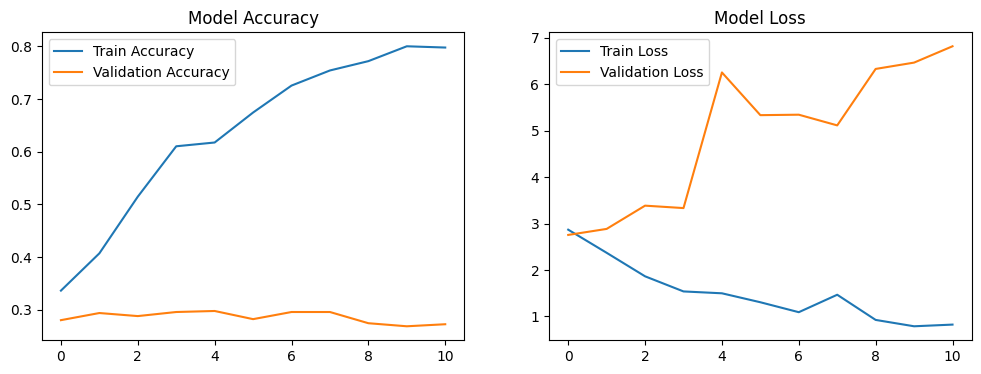

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_v1.history['accuracy'], label='Train Accuracy')
plt.plot(model_v1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(model_v1.history['loss'], label='Train Loss')
plt.plot(model_v1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

Only 30% accuracy on the validation set, it can be explained by several reasons, among them, unbalanced data classes and the simplicity of the architecture.

We ill use an already pre trained model ResNet now and see if it gives better results

In [33]:
def create_transfer_learning_model(input_shape, num_classes):
    # Load the pre-trained ResNet50 model without the top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    return model

In [34]:
# Create the transfer learning model
model_res = create_transfer_learning_model(input_shape, num_classes)

model_res.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_res.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [35]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose = 1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose = 1)

# Add ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_skin_disease_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [36]:
# Train the model

model_resnet = model_res.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 2.3889 - accuracy: 0.3743
Epoch 1: val_accuracy improved from -inf to 0.36944, saving model to best_skin_disease_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 589s 9s/step - loss: 2.3889 - accuracy: 0.3743 - val_loss: 2.0680 - val_accuracy: 0.3694 - lr: 0.0010
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 1.4919 - accuracy: 0.5416
Epoch 2: val_accuracy improved from 0.36944 to 0.39072, saving model to best_skin_disease_model.h5
66/66 [==============================] - 557s 8s/step - loss: 1.4919 - accuracy: 0.5416 - val_loss: 2.0771 - val_accuracy: 0.3907 - lr: 0.0010
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 1.1581 - accuracy: 0.6444
Epoch 3: val_accuracy improved from 0.39072 to 0.41586, saving model to best_skin_disease_model.h5
66/66 [==============================] - 559s 9s/step - loss: 1.1581 - accuracy: 0.6444 - val_loss: 2.1410 - val_accuracy: 0.4159 - lr: 0.0010
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.8669 - accuracy: 0.7337
Epoch 4: val_accuracy did not improve from 0.41586
66/66 [==============================] -

In [48]:
input_directory = '/content/drive/MyDrive/skin_disease/test'
output_directory = '/content/drive/MyDrive/skin_disease/test_resize'
target_size = (224, 224)

In [49]:
preprocess_images(input_directory, output_directory, target_size)

Preprocessing completed! Successfully processed 691 out of 691 images.


In [50]:
test_datagen = ImageDataGenerator()

test_dataset = test_datagen.flow_from_directory(
    output_directory,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 691 images belonging to 19 classes.


In [51]:
# After training, to load the best model:
best_model = tf.keras.models.load_model('best_skin_disease_model.h5')

# Evaluate using the best model
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test accuracy using best model: {test_accuracy:.4f}")

22/22 [==============================] - 145s 6s/step - loss: 1.6461 - accuracy: 0.5557
Test accuracy using best model: 0.5557


In [52]:
predictions = best_model.predict(test_dataset)

22/22 [==============================] - 145s 6s/step


In [54]:
predicted_classes = np.argmax(predictions, axis=1)

In [58]:
class_indices = test_dataset.class_indices
class_labels = {v: k for k, v in class_indices.items()}  # Invert the dictionary
predicted_labels = [class_labels[i] for i in predicted_classes]

print("Predictions (class labels):", predicted_labels)

Predictions (class labels): ['Acne and Rosacea Photos', 'Acne and Rosacea Photos', 'Poison Ivy Photos and other Contact Dermatitis', 'Acne and Rosacea Photos', 'Acne and Rosacea Photos', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Acne and Rosacea Photos', 'Vascular Tumors', 'Light Diseases and Disorders of Pigmentation', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Acne and Rosacea Photos', 'Acne and Rosacea Photos', 'Acne and Rosacea Photos', 'Acne and Rosacea Photos', 'Acne and Rosacea Photos', 'Light Diseases and Disorders of Pigmentation', 'Acne and Rosacea Photos', 'Acne and Rosacea Photos', 'Acne and Rosacea Photos', 'Acne and Rosacea Photos', 'Acne and Rosacea Photos', 'Light Diseases and Disorders of Pigmentation', 'Light Diseases and Disorders of Pigmentation', 'Acne and Rosacea Photos', 'Acne and Rosacea Photos', 'Warts Molluscum and other Viral Infections', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Acne a